# Introduction:
* Implementation of time-series clustering using the Household Power Consumption dataset and pretrained models.  
* The process includes dataset preparation, feature extraction using a pretrained model, clustering and evaluation of clustering quality.

# Step 1: Import Libraries


In [ ]:
# Basic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

# PyTorch for working with pretrained models
import torch
from torch import nn

# Install the transformers library if needed
# !pip install transformers
from transformers import AutoModel, AutoTokenizer


# Step 2: Load and Preprocess Data

In [ ]:
# Load the dataset
file_path = '/content/household_power_consumption.txt'
data = pd.read_csv(file_path, sep=';', parse_dates={'datetime': ['Date', 'Time']},
                   infer_datetime_format=True, low_memory=False, na_values='?')




<ipython-input-2-9d16c31de9d8>:3: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  data = pd.read_csv(file_path, sep=';', parse_dates={'datetime': ['Date', 'Time']},
<ipython-input-2-9d16c31de9d8>:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv(file_path, sep=';', parse_dates={'datetime': ['Date', 'Time']},
<ipython-input-2-9d16c31de9d8>:3: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data = pd.read_csv(file_path, sep=';', parse_dates={'datetime': ['Date', 'Time']},


In [ ]:
# Filter for a specific time range
data = data[(data['datetime'] >= '2007-01-01') & (data['datetime'] < '2007-01-08')]



In [ ]:
# Drop rows with missing values
data.dropna(inplace=True)



In [ ]:
# Select relevant columns for analysis
selected_columns = ['datetime', 'Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity']
data = data[selected_columns]

print(f"Data Shape: {data.shape}")
data.head()

Data Shape: (10080, 5)


,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity
21996,2007-01-01 00:00:00,2.580,0.136,241.97,10.6
21997,2007-01-01 00:01:00,2.552,0.100,241.75,10.4
21998,2007-01-01 00:02:00,2.550,0.100,241.64,10.4
21999,2007-01-01 00:03:00,2.550,0.100,241.71,10.4
22000,2007-01-01 00:04:00,2.554,0.100,241.98,10.4


In [ ]:
# Normalize the selected features
scaler = MinMaxScaler()
data[['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity']] = scaler.fit_transform(
    data[['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity']]
)

# Preview the normalized data
data.head()


,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity
21996,2007-01-01 00:00:00,0.303061,0.157773,0.660338,0.281609
21997,2007-01-01 00:01:00,0.299490,0.116009,0.651055,0.275862
21998,2007-01-01 00:02:00,0.299235,0.116009,0.646414,0.275862
21999,2007-01-01 00:03:00,0.299235,0.116009,0.649367,0.275862
22000,2007-01-01 00:04:00,0.299745,0.116009,0.660759,0.275862


# Step 3: Create Sliding Windows for Time-Series
Pretrained models often require fixed-length input sequences.

In [ ]:
# Function to create sliding windows
def create_sliding_windows(data, window_size, step_size):
    windows = []
    for i in range(0, len(data) - window_size + 1, step_size):
        windows.append(data[i:i + window_size].values)
    return np.array(windows)

# Set window size and step size
window_size = 60  # 60 minutes (1 hour)
step_size = 30    # 30 minutes step
time_series = data[['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity']]

# Create sliding windows
sliding_windows = create_sliding_windows(time_series, window_size, step_size)
print(f"Sliding Windows Shape: {sliding_windows.shape}")


Sliding Windows Shape: (335, 60, 4)


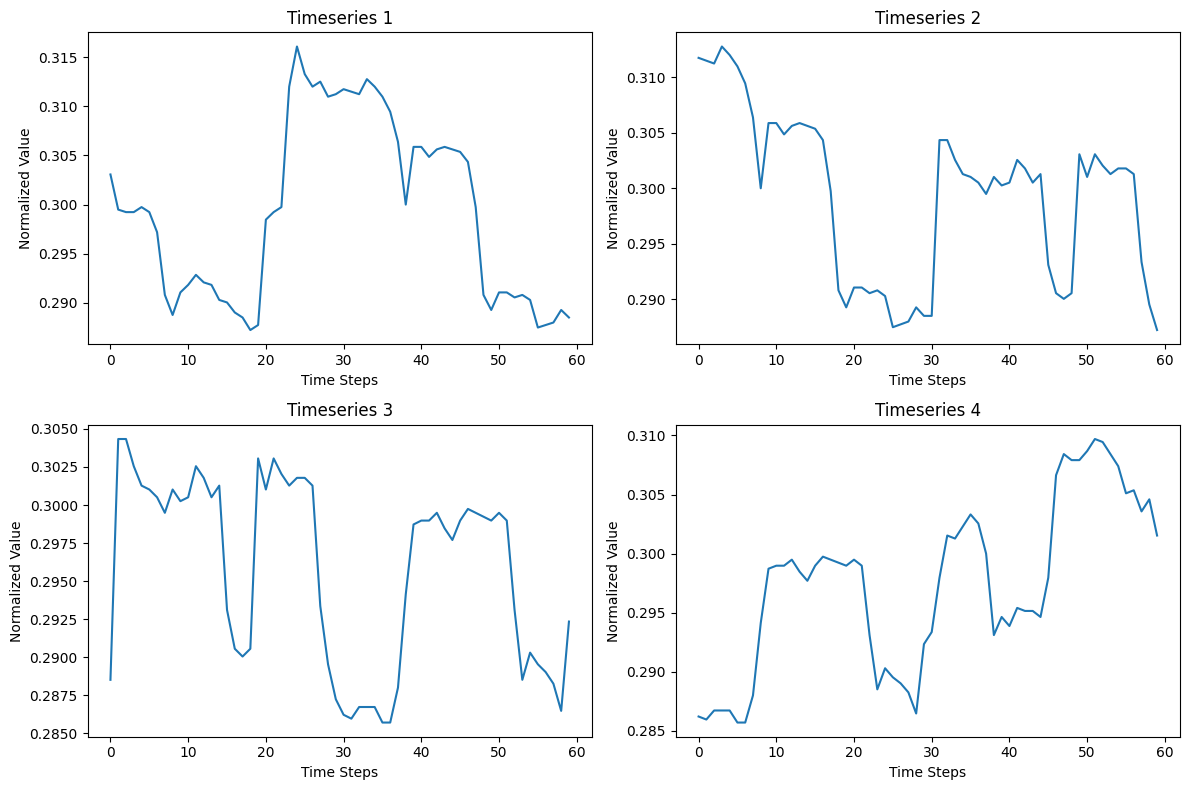

In [ ]:
import matplotlib.pyplot as plt

# Select a subset of data for visualization
# Using the first 4 sliding windows or time ranges for demonstration
plot_data = sliding_windows[:4]  # Extract the first 4 time-series windows
time_stamps = np.arange(plot_data.shape[1])  # Assume each time-series has the same length

# Plotting the time-series data
plt.figure(figsize=(12, 8))

# Plot each time-series in a grid
for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    plt.plot(time_stamps, plot_data[i][:, 0])  # Plot the first feature (e.g., Global_active_power)
    plt.title(f"Timeseries {i + 1}")
    plt.xlabel("Time Steps")
    plt.ylabel("Normalized Value")

plt.tight_layout()
plt.show()


# Step 4: Feature Extraction with a Pretrained Model
Use a pretrained model to extract features from the time-series.

In [ ]:
# Load a pretrained model
# model_name = "qianlima-lab/time-series-transformer"  # This model may be private or unavailable.
# model_name = "huggingface/pytorch-transformers"  # Using a publicly available model instead. This is incorrect
model_name = "google/bert_uncased_L-2_H-128_A-2"  # Using a publicly available and valid model instead.

model = AutoModel.from_pretrained(model_name)

# Assume the model takes 2D tensors as input
# input_tensor = torch.tensor(sliding_windows, dtype=torch.float32)

# Reshape the input to match BERT's expected input shape (batch_size, sequence_length, hidden_size)
input_tensor = torch.tensor(sliding_windows[:, :, 0], dtype=torch.float32).unsqueeze(-1)
input_tensor = input_tensor.repeat(1, 1, model.config.hidden_size) # repeating the feature to match hidden size

#  adjust the model input and feature extraction based on the new model's architecture.

with torch.no_grad():
    outputs = model(inputs_embeds=input_tensor)  # Using inputs_embeds for BERT
    encoded_features = outputs.last_hidden_state.mean(dim=1).numpy() # Mean pooling for feature reduction

print(f"Encoded Features Shape: {encoded_features.shape}")

Encoded Features Shape: (335, 128)


# Step 5: Clustering
Clustering the extracted features using K-Means.

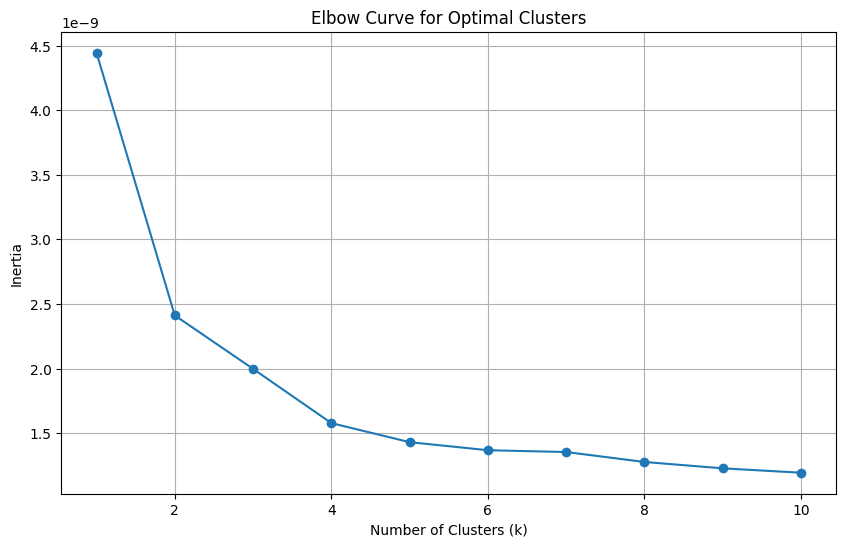

In [ ]:
# Range of cluster numbers to evaluate
cluster_range = range(1, 11)

# List to store inertia values
inertia_values = []

# Compute K-Means for each number of clusters and store inertia
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(encoded_features)  # Replace with your feature matrix
    inertia_values.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia_values, marker='o')
plt.title("Elbow Curve for Optimal Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.grid()
plt.show()


In [ ]:
# Perform clustering
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(encoded_features)

print(f"Cluster Assignments: {np.unique(clusters)}")


Cluster Assignments: [0 1 2 3]


# Step 6: Evaluate Clustering Quality
Using clustering metrics to evaluate the quality of clusters.

In [ ]:
# Evaluate clustering quality
sil_score = silhouette_score(encoded_features, clusters)
db_score = davies_bouldin_score(encoded_features, clusters)
ch_score = calinski_harabasz_score(encoded_features, clusters)

print(f"Silhouette Score: {sil_score}")
print(f"Davies-Bouldin Index: {db_score}")
print(f"Calinski-Harabasz Index: {ch_score}")


Silhouette Score: 0.34803324937820435
Davies-Bouldin Index: 1.310772379556071
Calinski-Harabasz Index: 962.1829197445533


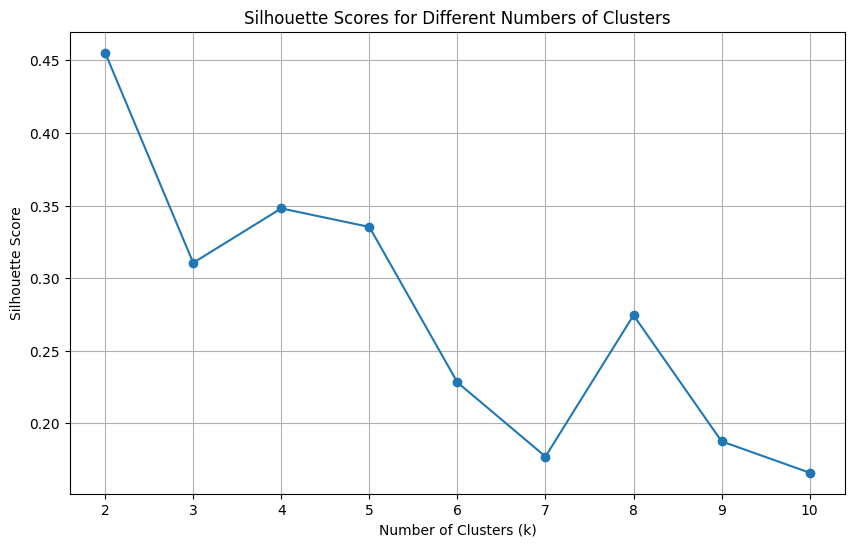

In [ ]:
from sklearn.metrics import silhouette_score

# Calculate silhouette scores for each k
silhouette_scores = []

for k in cluster_range[1:]:  # Silhouette Score is undefined for k=1
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(encoded_features)
    silhouette_scores.append(silhouette_score(encoded_features, labels))

# Plot Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(cluster_range[1:], silhouette_scores, marker='o')
plt.title("Silhouette Scores for Different Numbers of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid()
plt.show()


# Step 7: Visualize Clusters
Reduce dimensions to 2D using t-SNE for visualization.

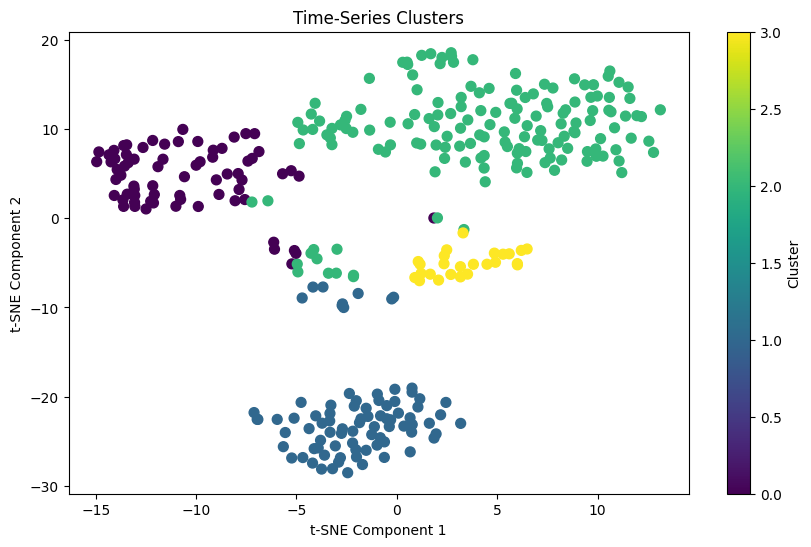

In [ ]:
# Dimensionality Reduction with t-SNE
tsne = TSNE(n_components=2, random_state=42)
reduced_features = tsne.fit_transform(encoded_features)

# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='viridis', s=50)
plt.title("Time-Series Clusters")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar(label="Cluster")
plt.show()


# Step 8: Save and Load Results

In [ ]:
# Add cluster labels to the dataset
data['Cluster'] = np.nan
data.iloc[:len(clusters) * step_size:step_size, -1] = clusters  # Add clusters for windows' start points

# Save the results
data.to_csv('clustering_results.csv', index=False)

# Summary:
* Load and preprocessed the dataset (subset and normalize).
* Created sliding windows for time-series clustering.
* Extracted features using a pretrained transformer model.
* Performed clustering using K-Means.
* Evaluated clustering quality with appropriate metrics.
* Visualized clusters using t-SNE.